# CFAR Part 2

Now we will fully implement CA-CFAR across Range Doppler and Range Azimuth data

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.insert(0, '..')
from utils.radar_params import *
from radar.range_processing import *
from radar.doppler_processing import *
from radar.azimuth_processing import *
from radar.cfar import *

%matplotlib inline

### Get Data

In [2]:
DATA_PATH = "../indoor_sample_50.h5"
CONFIG_PATH = "/home/iberrios/Documents/datasets/radical/data/radarcfg/indoor_human_rcs.cfg"

In [3]:
import h5py

data_dict = {}
with h5py.File(DATA_PATH, 'r') as h5_obj:
    for key in h5_obj.keys():
        data_dict.update({key : np.asarray(h5_obj[key])})

In [6]:
data_idx = 28
adc_data = data_dict['radar'][data_idx, ...]

### Get Range and Doppler bin values

In [7]:
with open(CONFIG_PATH, 'r') as f:
    for line in f.readlines():
        if 'profileCfg' in line:
            line = line.split(' ')

            start_freq = float(line[2]) # GHz
            idle_time = float(line[3]) # usec
            ramp_end_time = float(line[5]) # usec
            chirp_slope = float(line[8]) # MHz/usec
            num_adc_samples = float(line[10]) # unitless
            adc_sample_rate = float(line[11]) # Msps

        elif 'channelCfg' in line:
            line = line.split(' ')

            # number of receive antennas
            rx_bin = bin(int(line[1])).zfill(4)
            num_rx = len([i for i in rx_bin if i == '1'])

            # number of transmit antennas
            tx_bin = bin(int(line[2])).zfill(4)
            num_tx = len([i for i in tx_bin if i == '1'])


# print(f"Number of Rx Antennas: {num_rx}")
# print(f"Number of Tx Antennas: {num_tx}")
# print(f"Start Frequency: {start_freq} GHz")
# print(f"Idle Time: {idle_time} usec")
# print(f"Ramp End Time: {ramp_end_time} usec") # this should really be called ramp to end? or maybe just chirptime?
# print(f"Chirp Slope: {chirp_slope} MHz/usec")
# print(f"Number of ADC Samples: {num_adc_samples}")
# print(f"ADC sample rate: {adc_sample_rate} Msps")

In [8]:
range_resolution, bandwidth = compute_range_resolution(adc_sample_rate, num_adc_samples, chirp_slope)
max_range = range_resolution * num_adc_samples

num_chirps = adc_data.shape[0]
chirp_interval = (ramp_end_time + idle_time) * 1e-6 # usec

doppler_resolution = compute_doppler_resolution(num_chirps, bandwidth, chirp_interval, num_tx)
max_doppler = doppler_resolution * num_chirps / 2

### Process Data

In [9]:
# perform Fast Time Range FFT
range_cube = np.fft.fft(adc_data, axis=2).transpose(2, 1, 0)

# perform Slow Time Doppler FFT
range_doppler = np.fft.fftshift(np.fft.fft(range_cube, axis=2), axes=2)

# perform azimuth processing
steering_vector = compute_steering_vector(num_ant=8, angle_res=1, angle_rng=90)
range_azimuth = capon_spectrum(range_doppler, steering_vector)

## Apply CA-CFAR to Range Azimuth matrix

Don't take log before applying CFAR, we are computing the threshold assuming that the data follows an Exponential Distribution due to the square law detector that we are simulating by taking the square of the magnitude. If we take the log, then the data will follow more of a Normal Distribution and we will need to change our CFAR threshold computation to match this.

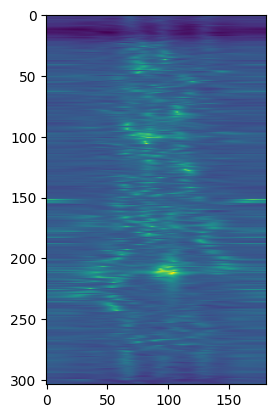

In [100]:
range_azimuth_psd = np.abs(range_azimuth)**2

plt.imshow(10*np.log10(range_azimuth_psd));

In [312]:
# cfar in range direction
noise_level_rng, threshold_rng = np.apply_along_axis(ca_cfar, 
                                                 axis=0, 
                                                 arr=range_azimuth_psd,
                                                 prob_fa=0.05, 
                                                 num_train=10, 
                                                 num_gaurd=3)

# cfar in azimuth direction
noise_level_az, threshold_az = np.apply_along_axis(ca_cfar, 
                                                 axis=0, 
                                                 arr=range_azimuth_psd.T,
                                                 prob_fa=0.05, 
                                                 num_train=10, 
                                                 num_gaurd=3)

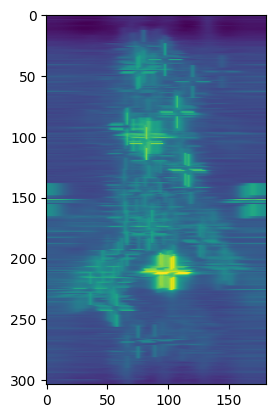

In [313]:
plt.imshow(np.log(threshold_rng + threshold_az.T));

### Get Peaks

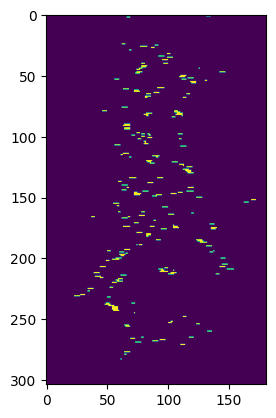

In [314]:
range_peaks = range_azimuth_psd > threshold_rng
azimuth_peaks = range_azimuth_psd > threshold_az.T

peaks = range_peaks & azimuth_peaks

plt.imshow(peaks);

Perform Non-Max Supression to reduce peaks

In [485]:
# def get_nhood(arr, x, y, nsize=2):
#     return arr[y-nsize:y+nsize+1, x-nsize:x+nsize+1]

def get_nhood(arr, x, y, axis=None, nsize=2):
    
    if not axis:
        hood = arr[y-nsize:y+nsize+1, x-nsize:x+nsize+1]
    elif axis == 0:
        hood = arr[y-nsize:y+nsize+1, x]
    elif axis == 1:
        hood = arr[y, x-nsize:x+nsize+1]

    return hood


def cfar_nms(cfar_peaks, signal_arr, nsize=2):
    """ Performs non-maximal supprression on detected CFAR peaks """
    nms_peaks = np.zeros(cfar_peaks.shape)
    for y, x in zip(*np.where(cfar_peaks == 1)):
        if np.all(signal_arr[y, x] >= get_nhood(signal_arr, x, y, nsize)):
            nms_peaks[y, x] = 1

    return nms_peaks


def cfar_nms_single_ax(cfar_peaks, signal_arr, axis=None, nsize=2):
    """ Performs non-maximal supprression on detected CFAR peaks """
    nms_peaks = np.zeros(cfar_peaks.shape)
    for y, x in zip(*np.where(cfar_peaks == 1)):
        if np.all(signal_arr[y, x] >= get_nhood(signal_arr, x, y, axis, nsize)):
            nms_peaks[y, x] = 1

    return nms_peaks

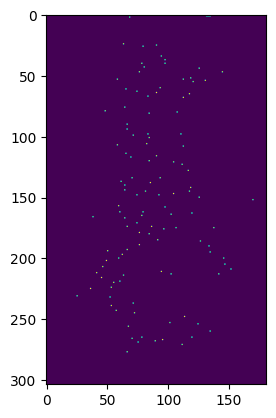

In [321]:
nms_peaks = cfar_nms(peaks, range_azimuth_psd, nsize=2)

plt.imshow(nms_peaks);

### Perform CFAR on Range Doppler PSD

For simplicity, we will consider each NMS Range and Azimuth location an individual target however, each range bin has corresponding Azimuth and Doppler components that could reveal additional target breakouts. 

In [107]:
# range_doppler_psd = 10*np.log10( np.abs(range_doppler)**2 ).sum(axis=1)
# range_doppler_psd = range_doppler_psd[::-1]

# get properly scaled range doppler power spectrum
range_doppler_psd = np.abs(range_doppler.sum(axis=1)/8)**2 
range_doppler_psd = 10*np.log10(range_doppler_psd)
# range_doppler_psd = range_doppler_psd - range_doppler_psd.min()

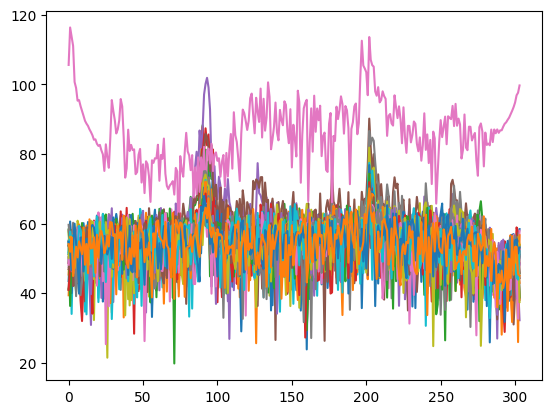

In [220]:
plt.plot(range_doppler_psd);

In [108]:
range_doppler_psd.min(), range_doppler_psd.max()

(19.829480816228692, 116.37817033916812)

In [371]:
range_doppler_mag = np.abs(range_doppler.sum(axis=1))**2

In [504]:
# cfar in range direction
noise_level_rng, threshold_rng = np.apply_along_axis(ca_cfar, 
                                                 axis=0, 
                                                 arr=range_doppler_mag,
                                                 prob_fa=0.0001, 
                                                 num_train=10, 
                                                 num_gaurd=2)

# cfar in Doppler direction
noise_level_dop, threshold_dop = np.apply_along_axis(ca_cfar, 
                                                 axis=0, 
                                                 arr=range_doppler_mag.T,
                                                 prob_fa=0.0001, 
                                                 num_train=10, 
                                                 num_gaurd=2)

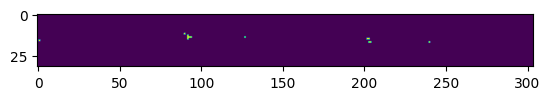

In [505]:
range_peaks = range_doppler_mag > threshold_rng
doppler_peaks = range_doppler_mag > threshold_dop.T

range_doppler_peaks = range_peaks & doppler_peaks

plt.imshow(range_doppler_peaks.T);

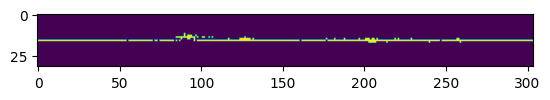

In [506]:
plt.imshow(doppler_peaks.T);

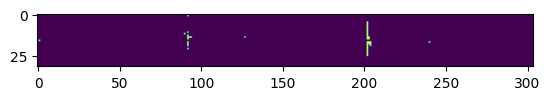

In [507]:
plt.imshow(range_peaks.T);

In [508]:
nms_doppler_peaks = cfar_nms_single_ax(doppler_peaks, range_doppler_mag, axis=1, nsize=1)

In [509]:
doppler_peaks.shape, range_doppler_mag.shape

((304, 32), (304, 32))

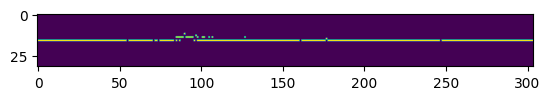

In [510]:
plt.imshow(nms_doppler_peaks.T);

Display Doppler Detections

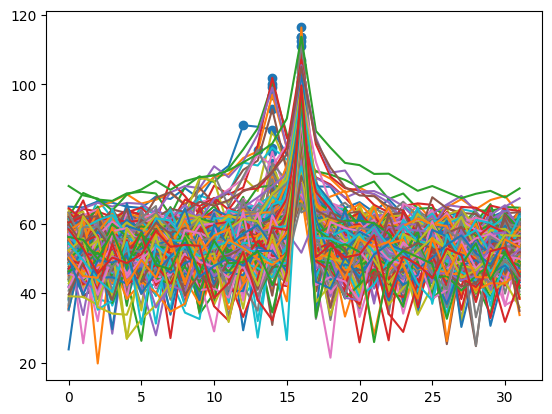

In [511]:
plt.plot(range_doppler_psd.T);
# plt.scatter(np.where(doppler_peaks)[1], 
#             range_doppler_psd[np.where(doppler_peaks)]);
plt.scatter(np.where(nms_doppler_peaks)[1], 
            range_doppler_psd[np.where(nms_doppler_peaks)]);

Display Range Detections

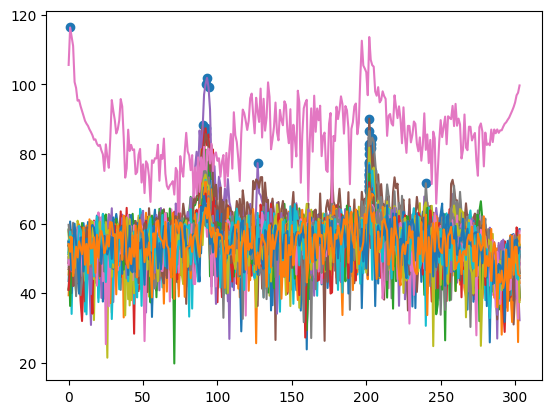

In [512]:
plt.plot(range_doppler_psd);
plt.scatter(np.where(range_peaks)[0], 
            range_doppler_psd[np.where(range_peaks)]);

In [515]:
# np.where(range_doppler_peaks)

In [516]:
range_locs, azimuth_locs = np.where(nms_peaks)
range_locs, azimuth_locs

(array([  1,   1,   1,   1,   2,  24,  25,  26,  34,  37,  40,  40,  43,
         44,  47,  47,  52,  53,  53,  54,  55,  60,  61,  63,  64,  65,
         67,  68,  76,  79,  80,  81,  90,  94,  98,  98,  99, 101, 106,
        107, 108, 114, 116, 117, 120, 121, 123, 128, 134, 134, 137, 138,
        140, 142, 144, 145, 145, 147, 148, 148, 150, 152, 157, 158, 162,
        162, 163, 164, 165, 166, 167, 171, 174, 174, 175, 175, 176, 179,
        180, 185, 186, 189, 190, 193, 194, 195, 197, 200, 200, 202, 205,
        207, 209, 211, 212, 213, 213, 214, 216, 219, 220, 224, 225, 231,
        232, 237, 239, 243, 245, 248, 253, 254, 256, 260, 265, 265, 266,
        267, 268, 269, 271, 277]),
 array([131, 132, 133, 134,  68,  63,  90,  79,  94,  97,  78,  97,  80,
        125,  76, 144, 118,  58, 112, 130, 120,  93,  65,  74,  90, 117,
         83, 112,  64,  48, 107,  84,  66,  66,  83, 110,  71,  84,  82,
         58, 112,  65,  90,  69,  84, 104, 111, 116,  70,  93,  61,  85,
         64, 118

In [517]:
ranges = (num_adc_samples - range_locs) * range_resolution
ranges

array([14.19180515, 14.19180515, 14.19180515, 14.19180515, 14.14496751,
       13.11453941, 13.06770177, 13.02086413, 12.64616301, 12.50565008,
       12.36513716, 12.36513716, 12.22462424, 12.1777866 , 12.03727368,
       12.03727368, 11.80308547, 11.75624783, 11.75624783, 11.70941019,
       11.66257255, 11.42838435, 11.38154671, 11.28787142, 11.24103378,
       11.19419614, 11.10052086, 11.05368322, 10.67898209, 10.53846917,
       10.49163153, 10.44479389, 10.02325512,  9.83590456,  9.648554  ,
        9.648554  ,  9.60171636,  9.50804108,  9.27385287,  9.22701523,
        9.18017759,  8.89915175,  8.80547646,  8.75863882,  8.6181259 ,
        8.57128826,  8.47761298,  8.24342477,  7.96239893,  7.96239893,
        7.82188601,  7.77504837,  7.68137309,  7.5876978 ,  7.49402252,
        7.44718488,  7.44718488,  7.3535096 ,  7.30667196,  7.30667196,
        7.21299668,  7.1193214 ,  6.88513319,  6.83829555,  6.65094499,
        6.65094499,  6.60410735,  6.55726971,  6.51043207,  6.46

In [518]:
angle_vector = np.arange(-90, 91, 1)
angles = angle_vector[azimuth_locs]

angles

array([ 41,  42,  43,  44, -22, -27,   0, -11,   4,   7, -12,   7, -10,
        35, -14,  54,  28, -32,  22,  40,  30,   3, -25, -16,   0,  27,
        -7,  22, -26, -42,  17,  -6, -24, -24,  -7,  20, -19,  -6,  -8,
       -32,  22, -25,   0, -21,  -6,  14,  21,  26, -20,   3, -29,  -5,
       -26,  28, -26,  -9,  27,  14, -16,   2,  35,  79, -31,   7, -30,
       -11,  29,  12, -12, -52, -26, -16, -24,  -4,  16,  47,   6, -14,
        -6,   1,  36, -14,  43, -24, -40,  44, -28, -31,  55, -41,  56,
       -44,  61,   4, -49,  12,  51, -27, -45, -30, -35, -37, -54, -65,
       -38, -19, -37, -33, -18,  23,  11,  34, -23,  44, -12,  29, -20,
         5,  -1, -15,  21, -24])

In [519]:
range_doppler_psd[range_locs, :].shape

(122, 32)

#### Generate CFAR Point Cloud

Each entry to this point cloud contains (range, Azimuth, 32 Doppler Velocity values), in the 3D case we would have an additional entry for Elevation angle.

In [520]:
cfar_cloud = np.hstack((ranges[:, None], 
                        angles[:, None], 
                        range_doppler_psd[int(num_adc_samples) - range_locs, :])
                        )
cfar_cloud.shape

(122, 34)

In [521]:
tmp = doppler_peaks[int(num_adc_samples) - range_locs, :]
tmp = nms_doppler_peaks[int(num_adc_samples) - range_locs, :]

valid = np.any(tmp, axis=1)

valid.shape, tmp.shape

((122,), (122, 32))

In [522]:
np.where(tmp)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  86,  87,  88,  89,
         89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99,  99, 101,
        102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
        115, 116, 117, 118, 119, 120, 121]),
 array([16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
        16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
        16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
        16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16

In [523]:
true_pad = np.ones((122, 2), dtype=bool)

tmp2 = np.hstack((true_pad, tmp))
tmp2.shape

(122, 34)

In [524]:
detected_ranges = ranges[np.where(tmp)[0]]
detected_angles = angles[np.where(tmp)[0]]
detected_dopplers = np.where(tmp)[1] # Doppler Bins
detected_doppler_mag = cfar_cloud[np.where(tmp)[0], np.where(tmp)[1] + 2]

In [525]:
detected_ranges.shape, detected_angles.shape, detected_dopplers.shape

((124,), (124,), (124,))

In [526]:
detections = np.stack((detected_ranges, detected_angles, detected_dopplers, detected_doppler_mag)).T
detections.shape

(124, 4)

In [527]:
angles.shape, ranges.shape, angles

((122,),
 (122,),
 array([ 41,  42,  43,  44, -22, -27,   0, -11,   4,   7, -12,   7, -10,
         35, -14,  54,  28, -32,  22,  40,  30,   3, -25, -16,   0,  27,
         -7,  22, -26, -42,  17,  -6, -24, -24,  -7,  20, -19,  -6,  -8,
        -32,  22, -25,   0, -21,  -6,  14,  21,  26, -20,   3, -29,  -5,
        -26,  28, -26,  -9,  27,  14, -16,   2,  35,  79, -31,   7, -30,
        -11,  29,  12, -12, -52, -26, -16, -24,  -4,  16,  47,   6, -14,
         -6,   1,  36, -14,  43, -24, -40,  44, -28, -31,  55, -41,  56,
        -44,  61,   4, -49,  12,  51, -27, -45, -30, -35, -37, -54, -65,
        -38, -19, -37, -33, -18,  23,  11,  34, -23,  44, -12,  29, -20,
          5,  -1, -15,  21, -24]))

In [528]:
ranges

array([14.19180515, 14.19180515, 14.19180515, 14.19180515, 14.14496751,
       13.11453941, 13.06770177, 13.02086413, 12.64616301, 12.50565008,
       12.36513716, 12.36513716, 12.22462424, 12.1777866 , 12.03727368,
       12.03727368, 11.80308547, 11.75624783, 11.75624783, 11.70941019,
       11.66257255, 11.42838435, 11.38154671, 11.28787142, 11.24103378,
       11.19419614, 11.10052086, 11.05368322, 10.67898209, 10.53846917,
       10.49163153, 10.44479389, 10.02325512,  9.83590456,  9.648554  ,
        9.648554  ,  9.60171636,  9.50804108,  9.27385287,  9.22701523,
        9.18017759,  8.89915175,  8.80547646,  8.75863882,  8.6181259 ,
        8.57128826,  8.47761298,  8.24342477,  7.96239893,  7.96239893,
        7.82188601,  7.77504837,  7.68137309,  7.5876978 ,  7.49402252,
        7.44718488,  7.44718488,  7.3535096 ,  7.30667196,  7.30667196,
        7.21299668,  7.1193214 ,  6.88513319,  6.83829555,  6.65094499,
        6.65094499,  6.60410735,  6.55726971,  6.51043207,  6.46

In [529]:
detections

array([[ 14.19180515,  41.        ,  16.        ,  99.7191757 ],
       [ 14.19180515,  42.        ,  16.        ,  99.7191757 ],
       [ 14.19180515,  43.        ,  16.        ,  99.7191757 ],
       [ 14.19180515,  44.        ,  16.        ,  99.7191757 ],
       [ 14.14496751, -22.        ,  16.        ,  97.63140895],
       [ 13.11453941, -27.        ,  16.        ,  86.17151482],
       [ 13.06770177,   0.        ,  16.        ,  76.4631267 ],
       [ 13.02086413, -11.        ,  16.        ,  86.51813958],
       [ 12.64616301,   4.        ,  16.        ,  87.83436018],
       [ 12.50565008,   7.        ,  16.        ,  81.86098106],
       [ 12.36513716, -12.        ,  16.        ,  78.7250928 ],
       [ 12.36513716,   7.        ,  16.        ,  78.7250928 ],
       [ 12.22462424, -10.        ,  16.        ,  88.15192957],
       [ 12.1777866 ,  35.        ,  16.        ,  94.42803888],
       [ 12.03727368, -14.        ,  16.        ,  90.04667419],
       [ 12.03727368,  54

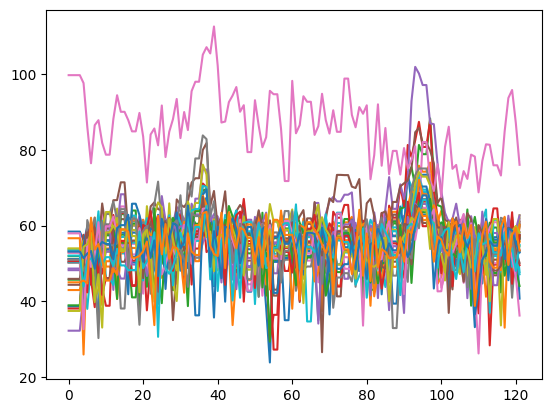

In [357]:
plt.plot(cfar_cloud[:, 2:]);

In [349]:
np.where(doppler_peaks)[0]

array([  0,   1,   2,   3,   4,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  18,  19,  20,  21,  22,  23,
        24,  25,  26,  27,  28,  29,  29,  30,  31,  32,  33,  34,  35,
        36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,
        49,  50,  51,  52,  53,  54,  55,  55,  56,  57,  58,  59,  60,
        61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,
        75,  76,  77,  77,  78,  79,  80,  81,  82,  82,  83,  84,  84,
        84,  85,  85,  86,  86,  86,  87,  87,  87,  88,  88,  89,  89,
        89,  89,  89,  90,  90,  90,  91,  91,  91,  91,  92,  92,  92,
        93,  93,  93,  93,  94,  94,  94,  95,  95,  95,  95,  96,  96,
        96,  96,  97,  98,  98,  99,  99, 100, 100, 101, 101, 102, 102,
       102, 102, 103, 104, 104, 105, 105, 106, 106, 106, 107, 107, 108,
       108, 109, 109, 110, 111, 112, 113, 113, 114, 115, 115, 116, 117,
       117, 118, 118, 119, 120, 121, 122, 122, 123, 124, 124, 12

In [350]:
np.where(doppler_peaks)[1]

array([16, 16, 16, 16, 16, 30, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16,  3, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 14, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 29, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 16, 16, 16, 16,
       16, 14, 16, 16, 14, 15, 16, 14, 16, 14, 15, 16, 14, 15, 16, 14, 15,
       12, 13, 14, 15, 16, 12, 13, 14, 13, 14, 15, 16, 13, 14, 15, 13, 14,
       15, 16, 13, 14, 15, 13, 14, 15, 16, 13, 14, 15, 16, 13, 14, 16, 15,
       16, 14, 16, 14, 16, 13, 14, 15, 16, 16, 15, 16, 14, 16, 14, 15, 16,
       14, 16, 14, 16, 14, 16, 16, 16, 16, 15, 16, 16, 15, 16, 16, 15, 16,
       15, 16, 16, 16, 16, 14, 16, 16, 15, 16, 15, 16, 14, 15, 16, 14, 15,
       16, 14, 15, 16, 14, 15, 16, 15, 16, 16, 15, 16, 14, 15, 16, 15, 16,
       16, 16, 14, 15, 16, 16, 16, 14, 16, 14, 15, 16, 16, 16, 15, 16, 16,
       15, 16, 16, 16, 16

In [343]:
doppler_peaks.shape

(304, 32)

In [205]:
cfar_cloud[92:96, 0]

array([4.44957587, 4.35590059, 4.30906295, 4.26222531])

In [206]:
cfar_cloud[92:96, 1]

array([ 61.,   4., -49.,  12.])

In [215]:
cfar_cloud[92:96, 16]

array([ 92.86684242, 101.9068696 , 100.15842333,  97.11567527])

In [210]:
cfar_cloud[93, 1], cfar_cloud[95, 1]

(4.0, 12.0)

View Doppler Target breakout

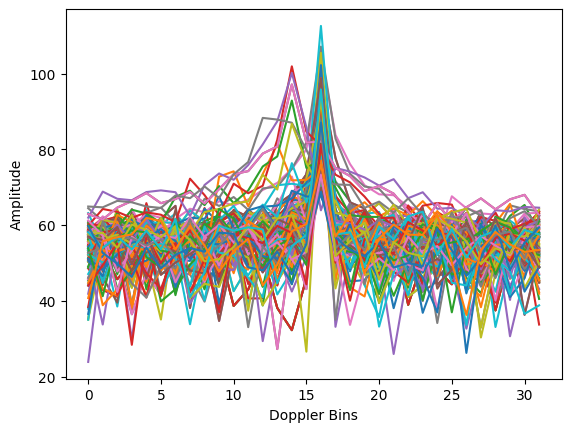

In [311]:
plt.plot(cfar_cloud[:, 2:].T);
plt.xlabel("Doppler Bins");
plt.ylabel("Amplitude");

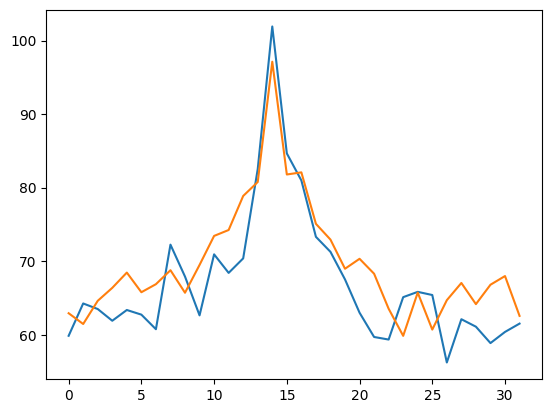

In [213]:
plt.plot(cfar_cloud[93, 2:], label='target 1');
plt.plot(cfar_cloud[95, 2:], label='target 2');

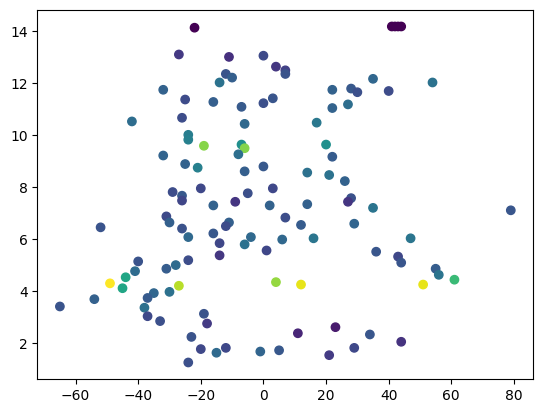

In [216]:
plt.scatter(cfar_cloud[:, 1], cfar_cloud[:, 0], c=cfar_cloud[:, 2:].sum(axis=1));

In [219]:
cfar_cloud[:, 2:].sum(axis=1) 

array([1611.98189856, 1611.98189856, 1611.98189856, 1611.98189856,
       1610.83949911, 1717.52869318, 1753.83844541, 1699.59717708,
       1713.18642548, 1735.20700763, 1774.77783928, 1774.77783928,
       1803.22216148, 1822.58379709, 1852.31915828, 1852.31915828,
       1788.36559217, 1809.06625396, 1809.06625396, 1756.67234882,
       1767.78392278, 1779.97593378, 1757.01879248, 1801.10394822,
       1767.78192815, 1840.82486921, 1788.65927598, 1812.67404487,
       1760.84558022, 1837.11343699, 1866.81900046, 1827.06716992,
       1879.88031176, 1887.68150299, 1929.92157445, 1929.92157445,
       2135.70822137, 2133.3083702 , 1843.22437602, 1814.95525398,
       1794.25395438, 1809.82254779, 1787.73397154, 1887.41561281,
       1803.01557435, 1847.20916268, 1851.2295073 , 1810.08359486,
       1749.65362859, 1749.65362859, 1758.95896191, 1764.47229459,
       1786.22802161, 1772.50940597, 1744.68073328, 1708.87275013,
       1708.87275013, 1808.41239481, 1810.04259483, 1810.04259

In [186]:
cfar_cloud[:, 0]

array([14.19180515, 14.19180515, 14.19180515, 14.19180515, 14.14496751,
       13.11453941, 13.06770177, 13.02086413, 12.64616301, 12.50565008,
       12.36513716, 12.36513716, 12.22462424, 12.1777866 , 12.03727368,
       12.03727368, 11.80308547, 11.75624783, 11.75624783, 11.70941019,
       11.66257255, 11.42838435, 11.38154671, 11.28787142, 11.24103378,
       11.19419614, 11.10052086, 11.05368322, 10.67898209, 10.53846917,
       10.49163153, 10.44479389, 10.02325512,  9.83590456,  9.648554  ,
        9.648554  ,  9.60171636,  9.50804108,  9.27385287,  9.22701523,
        9.18017759,  8.89915175,  8.80547646,  8.75863882,  8.6181259 ,
        8.57128826,  8.47761298,  8.24342477,  7.96239893,  7.96239893,
        7.82188601,  7.77504837,  7.68137309,  7.5876978 ,  7.49402252,
        7.44718488,  7.44718488,  7.3535096 ,  7.30667196,  7.30667196,
        7.21299668,  7.1193214 ,  6.88513319,  6.83829555,  6.65094499,
        6.65094499,  6.60410735,  6.55726971,  6.51043207,  6.46

In [185]:
cfar_cloud[:, 18]

array([ 99.7191757 ,  99.7191757 ,  99.7191757 ,  99.7191757 ,
        97.63140895,  86.17151482,  76.4631267 ,  86.51813958,
        87.83436018,  81.86098106,  78.7250928 ,  78.7250928 ,
        88.15192957,  94.42803888,  90.04667419,  90.04667419,
        87.83787456,  84.88272891,  84.88272891,  89.76007254,
        83.46032988,  71.3865449 ,  84.06403518,  85.64518945,
        81.2029562 ,  91.71453749,  78.10125666,  84.78838412,
        88.11812288,  93.43337373,  83.10852458,  89.99355947,
        85.23114814,  95.50248537,  97.98418572,  97.98418572,
       105.11508884, 107.1055068 , 105.45571535, 112.57042017,
       102.23027723,  87.21202161,  87.47554746,  92.60348982,
        94.35109853,  96.58566787,  90.06269289,  91.79243503,
        79.41018347,  79.41018347,  93.1066429 ,  86.40604717,
        80.68838515,  83.33190722,  95.58936263,  94.68629827,
        94.68629827,  85.48345849,  71.76533812,  71.76533812,
        98.21481039,  84.37339626,  86.5301521 ,  94.15

## Now we can cluster the cloud to generate detections

In [187]:
from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=20, min_samples=2)
clustering.fit(cfar_cloud)

DBSCAN(eps=20, min_samples=2)

In [188]:
clustering.labels_

array([ 0,  0,  0,  0, -1, -1, -1, -1, -1, -1,  1,  1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1,  2,  2, -1, -1, -1, -1,  3,  3, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1])

In [189]:
cfar_cloud[clustering.labels_ == 2][:, 1], cfar_cloud[clustering.labels_ == 2][:, 0]

(array([-16.,   2.]), array([7.30667196, 7.30667196]))

In [190]:
def get_color(number):
    """ Converts an integer number to a color """
    # change these however you want to
    blue = int(number*30 % 256)
    green = int(number*103 % 256)
    red = int(number*50 % 256)

    return red, blue, green

In [191]:
hex(color[0])

'0xe4'

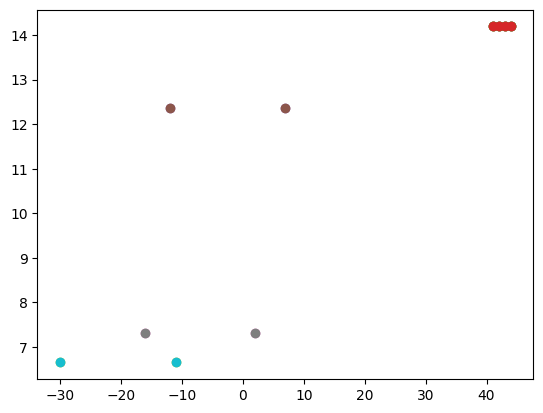

In [192]:
for i, lbl in enumerate(clustering.labels_):
    if lbl >= 0:
        color = get_color(i+1)
        az = cfar_cloud[clustering.labels_ == lbl][:, 1]
        rng = cfar_cloud[clustering.labels_ == lbl][:, 0]
        plt.scatter(az, rng) # , c=hex(color[0]));

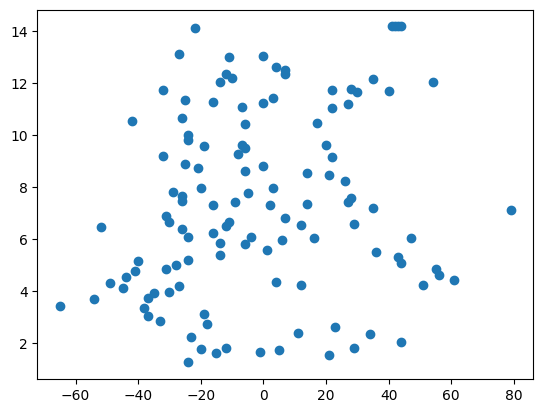

In [134]:
plt.scatter(cfar_cloud[:, 1], cfar_cloud[:, 0])

Should we just check each point and determine of multiple targets are present?

In [262]:
range_locs[idx], azimuth_locs[idx].shape

(array([  1,   1,   1,   1,   2,  60,  64,  79,  90,  94, 128, 134, 134,
        140, 163, 165, 175, 175, 176, 180, 197, 202, 205, 213, 213, 219,
        239, 254, 256, 260]),
 (30,))

In [271]:
range_doppler_psd[range_locs[idx], :].shape

(30, 32)

In [248]:
range_detections = np.intersect1d(range_locs, np.where(range_doppler_peaks)[0])
range_detections

array([  1,   2,  60,  64,  79,  90,  94, 128, 134, 140, 163, 165, 175,
       176, 180, 197, 202, 205, 213, 219, 239, 254, 256, 260])

In [256]:
range_locs

array([  1,   1,   1,   1,   2,  24,  25,  26,  34,  37,  40,  40,  43,
        44,  47,  47,  52,  53,  53,  54,  55,  60,  61,  63,  64,  65,
        67,  68,  76,  79,  80,  81,  90,  94,  98,  98,  99, 101, 106,
       107, 108, 114, 116, 117, 120, 121, 123, 128, 134, 134, 137, 138,
       140, 142, 144, 145, 145, 147, 148, 148, 150, 152, 157, 158, 162,
       162, 163, 164, 165, 166, 167, 171, 174, 174, 175, 175, 176, 179,
       180, 185, 186, 189, 190, 193, 194, 195, 197, 200, 200, 202, 205,
       207, 209, 211, 212, 213, 213, 214, 216, 219, 220, 224, 225, 231,
       232, 237, 239, 243, 245, 248, 253, 254, 256, 260, 265, 265, 266,
       267, 268, 269, 271, 277])

In [255]:
np.where(range_locs == range_detections[0])

(array([0, 1, 2, 3]),)

In [254]:
range_azimuth_psd[range_detections].shape, range_doppler_psd[range_detections].shape

((24, 181), (24, 32))

In [ ]:
azimuth_detections =

## General Approach (a little sparse)

Now we can combine the CFAR Range Azimuth Detections with the Range Doppler Data to get a 'Point Cloud'. We can then cluster the point cloud in 3D space to obtain detections

- CFAR on Range Azimuth
- Get corresponding Ranges on Range Doppler matrix
- Combine Range, Azimuth, and Doppler into a 3D data structure

## OR Extra Sparse Approach

correlate Range Az detections with Range Doppler before generating 2D 'cloud' (flat cloud) (cloud layer)

- CFAR on Range Azimuth
- CFAR on Range Doppler
- Find Ranges in Range-Azimuth that correspond to Ranges in Range-Doppler, generate range index
- Use Range index to find valid range and azimuth detections and their corresponding Doppler 
- Place everything in a 3D data structure

After either of these methods, we are now ready to start making detections on targets

In [45]:
range_locs, azimuth_locs = np.where(nms_peaks)

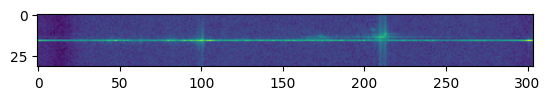

In [43]:
plt.imshow(range_doppler_psd.T);

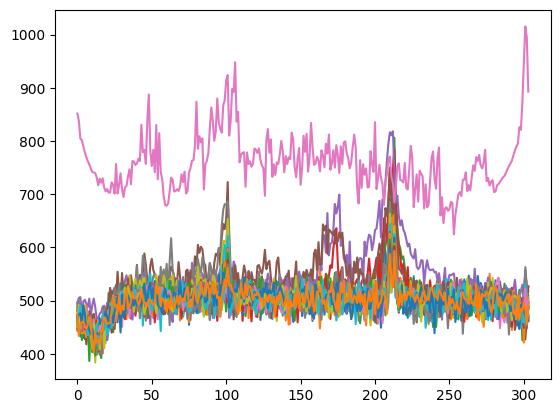

In [44]:
plt.plot(range_doppler_psd);

In [98]:
rng_dop[10, :]

array([503.19400645, 501.99690755, 521.14715548, 505.23115516,
       499.70495715, 482.95809595, 513.89977345, 492.57051691,
       487.25073931, 521.41632866, 503.23140724, 525.36375761,
       504.66192894, 498.6855804 , 523.08932055, 567.12378408,
       757.74495875, 565.29883925, 519.16461064, 491.74902605,
       516.78271681, 481.57796264, 495.25149987, 500.62799163,
       506.38623949, 513.36152179, 487.90780369, 487.31180828,
       492.86376888, 492.28336163, 490.82331569, 503.6139752 ])

In [124]:
rng_az = range_azimuth_psd[range_locs, azimuth_locs]
rng_dop = range_doppler_psd[range_locs, :]

cfar_cloud = np.concatenate((range_locs[:, None, None], azimuth_locs[:, None, None], rng_dop[:, :, None]), axis=1)

In [130]:
range_locs[:, None, None].shape, azimuth_locs[None, :, None].shape, rng_dop[:, None, :].shape

((122, 1, 1), (1, 122, 1), (122, 1, 32))

In [159]:
cfar_cloud = rng_dop[None, None, :, :].repeat(len(range_locs), axis=0).repeat(len(azimuth_locs), axis=1)
cfar_cloud.shape

(122, 122, 122, 32)

In [165]:
range_locs[:, None, None].shape, azimuth_locs[None, :, None].shape, rng_dop[None, None, :, :].shape

((122, 1, 1), (1, 122, 1), (1, 1, 122, 32))

In [172]:
print(range_locs[:, None, None, None].repeat(32, axis=-1).shape,
    azimuth_locs[None, :, None].repeat(32, axis=-1).shape,
    rng_dop[None, :, :].shape)

(122, 1, 32) (1, 122, 32) (1, 122, 32)


In [182]:
np.tile(range_locs[:, None, None], reps=(1, 122, 32)).shape, np.tile(azimuth_locs[:, None, None], reps=(1, 122, 32)).shape

((122, 122, 32), (122, 122, 32))

In [187]:
np.tile(rng_dop[None, :, :], reps=(122, 1, 1)).shape

(122, 122, 32)

In [189]:
cfar_cloud = np.stack((
    np.tile(range_locs[:, None, None], reps=(1, 122, 32)),
    np.tile(azimuth_locs[:, None, None], reps=(1, 122, 32)), 
    np.tile(rng_dop[None, :, :], reps=(122, 1, 1))), axis=-1)


cfar_cloud.shape

(122, 122, 32, 3)

In [202]:
cfar_cloud = np.concatenate((
    np.tile(range_locs[:, None, None], reps=(1, 122, 1)),
    np.tile(azimuth_locs[:, None, None], reps=(1, 122, 1)), 
    np.tile(rng_dop[None, :, :], reps=(122, 1, 1))), axis=2)


cfar_cloud.shape

(122, 122, 34)

In [203]:
cfar_cloud[0, 0,  :]

array([  1.        , 131.        , 491.02052339, 479.45778583,
       448.68304314, 456.03355941, 440.48091458, 465.32999063,
       487.13839947, 467.30112082, 459.80396762, 463.39979467,
       449.74816329, 449.40790934, 474.69989281, 464.85454125,
       505.22247543, 472.555221  , 837.5951118 , 499.78361028,
       483.95496027, 466.7801445 , 468.39394765, 465.22691227,
       481.34659961, 482.38700231, 444.36574901, 477.13838098,
       458.56701196, 476.74491424, 492.3430912 , 473.91526592,
       474.59241666, 433.56432468])

In [153]:
azimuth_locs

array([131, 132, 133, 134,  68,  63,  90,  79,  94,  97,  78,  97,  80,
       125,  76, 144, 118,  58, 112, 130, 120,  93,  65,  74,  90, 117,
        83, 112,  64,  48, 107,  84,  66,  66,  83, 110,  71,  84,  82,
        58, 112,  65,  90,  69,  84, 104, 111, 116,  70,  93,  61,  85,
        64, 118,  64,  81, 117, 104,  74,  92, 125, 169,  59,  97,  60,
        79, 119, 102,  78,  38,  64,  74,  66,  86, 106, 137,  96,  76,
        84,  91, 126,  76, 133,  66,  50, 134,  62,  59, 145,  49, 146,
        46, 151,  94,  41, 102, 141,  63,  45,  60,  55,  53,  36,  25,
        52,  71,  53,  57,  72, 113, 101, 124,  67, 134,  78, 119,  70,
        95,  89,  75, 111,  66])

In [151]:
range_locs

array([  1,   1,   1,   1,   2,  24,  25,  26,  34,  37,  40,  40,  43,
        44,  47,  47,  52,  53,  53,  54,  55,  60,  61,  63,  64,  65,
        67,  68,  76,  79,  80,  81,  90,  94,  98,  98,  99, 101, 106,
       107, 108, 114, 116, 117, 120, 121, 123, 128, 134, 134, 137, 138,
       140, 142, 144, 145, 145, 147, 148, 148, 150, 152, 157, 158, 162,
       162, 163, 164, 165, 166, 167, 171, 174, 174, 175, 175, 176, 179,
       180, 185, 186, 189, 190, 193, 194, 195, 197, 200, 200, 202, 205,
       207, 209, 211, 212, 213, 213, 214, 216, 219, 220, 224, 225, 231,
       232, 237, 239, 243, 245, 248, 253, 254, 256, 260, 265, 265, 266,
       267, 268, 269, 271, 277])

In [156]:
cfar_cloud[:, 0, 0]

array([  1.,   1.,   1.,   1.,   2.,  24.,  25.,  26.,  34.,  37.,  40.,
        40.,  43.,  44.,  47.,  47.,  52.,  53.,  53.,  54.,  55.,  60.,
        61.,  63.,  64.,  65.,  67.,  68.,  76.,  79.,  80.,  81.,  90.,
        94.,  98.,  98.,  99., 101., 106., 107., 108., 114., 116., 117.,
       120., 121., 123., 128., 134., 134., 137., 138., 140., 142., 144.,
       145., 145., 147., 148., 148., 150., 152., 157., 158., 162., 162.,
       163., 164., 165., 166., 167., 171., 174., 174., 175., 175., 176.,
       179., 180., 185., 186., 189., 190., 193., 194., 195., 197., 200.,
       200., 202., 205., 207., 209., 211., 212., 213., 213., 214., 216.,
       219., 220., 224., 225., 231., 232., 237., 239., 243., 245., 248.,
       253., 254., 256., 260., 265., 265., 266., 267., 268., 269., 271.,
       277.])

In [140]:
cfar_cloud = np.dstack((range_locs[:, None, None], azimuth_locs[None, :, None], rng_dop[:, None, :]))

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 122 and the array at index 1 has size 1

In [126]:
cfar_cloud.shape

(122, 34, 1)

In [101]:
range_locs.shape, azimuth_locs.shape, rng_dop.shape

((122,), (122,), (122, 32))

In [105]:
steering_vector.shape

(181, 8)

In [103]:
azimuth_locs

array([131, 132, 133, 134,  68,  63,  90,  79,  94,  97,  78,  97,  80,
       125,  76, 144, 118,  58, 112, 130, 120,  93,  65,  74,  90, 117,
        83, 112,  64,  48, 107,  84,  66,  66,  83, 110,  71,  84,  82,
        58, 112,  65,  90,  69,  84, 104, 111, 116,  70,  93,  61,  85,
        64, 118,  64,  81, 117, 104,  74,  92, 125, 169,  59,  97,  60,
        79, 119, 102,  78,  38,  64,  74,  66,  86, 106, 137,  96,  76,
        84,  91, 126,  76, 133,  66,  50, 134,  62,  59, 145,  49, 146,
        46, 151,  94,  41, 102, 141,  63,  45,  60,  55,  53,  36,  25,
        52,  71,  53,  57,  72, 113, 101, 124,  67, 134,  78, 119,  70,
        95,  89,  75, 111,  66])

In [102]:
rng_dop[0, :]

array([491.02052339, 479.45778583, 448.68304314, 456.03355941,
       440.48091458, 465.32999063, 487.13839947, 467.30112082,
       459.80396762, 463.39979467, 449.74816329, 449.40790934,
       474.69989281, 464.85454125, 505.22247543, 472.555221  ,
       837.5951118 , 499.78361028, 483.95496027, 466.7801445 ,
       468.39394765, 465.22691227, 481.34659961, 482.38700231,
       444.36574901, 477.13838098, 458.56701196, 476.74491424,
       492.3430912 , 473.91526592, 474.59241666, 433.56432468])

In [87]:
rng_az[None, None, :].shape, rng_dop[:, :, None].shape

((1, 1, 122), (122, 32, 1))

In [94]:
np.concatenate((rng_az[:, None, None], rng_dop[:, :, None]), axis=1).shape

(122, 33, 1)

In [81]:
rng_az[:, None].shape, rng_dop.shape

((122, 1), (122, 32))

In [82]:
cfar_cloud.shape

(122, 33, 1)

In [96]:
rng_az.shape

(122,)

In [95]:
tmp = rng_dop[:, :, None].repeat(len(ra))
tmp.shape

(122, 32, 1)

In [66]:
rng_az_detect[:, None].shape, rng_dop_detect.shape

((122, 1), (122, 32))

In [54]:
range_locs

array([  1,   1,   1,   1,   2,  24,  25,  26,  34,  37,  40,  40,  43,
        44,  47,  47,  52,  53,  53,  54,  55,  60,  61,  63,  64,  65,
        67,  68,  76,  79,  80,  81,  90,  94,  98,  98,  99, 101, 106,
       107, 108, 114, 116, 117, 120, 121, 123, 128, 134, 134, 137, 138,
       140, 142, 144, 145, 145, 147, 148, 148, 150, 152, 157, 158, 162,
       162, 163, 164, 165, 166, 167, 171, 174, 174, 175, 175, 176, 179,
       180, 185, 186, 189, 190, 193, 194, 195, 197, 200, 200, 202, 205,
       207, 209, 211, 212, 213, 213, 214, 216, 219, 220, 224, 225, 231,
       232, 237, 239, 243, 245, 248, 253, 254, 256, 260, 265, 265, 266,
       267, 268, 269, 271, 277])

In [53]:
range_doppler_psd[range_locs, :][0, :]

array([491.02052339, 479.45778583, 448.68304314, 456.03355941,
       440.48091458, 465.32999063, 487.13839947, 467.30112082,
       459.80396762, 463.39979467, 449.74816329, 449.40790934,
       474.69989281, 464.85454125, 505.22247543, 472.555221  ,
       837.5951118 , 499.78361028, 483.95496027, 466.7801445 ,
       468.39394765, 465.22691227, 481.34659961, 482.38700231,
       444.36574901, 477.13838098, 458.56701196, 476.74491424,
       492.3430912 , 473.91526592, 474.59241666, 433.56432468])